# Symmetry Reduced VQE

The first step is to find the blocks of a Hamiltonian which has have been reduced due to the application of some symmerty consideration.  Each block will then have an associated wavefunction,
$$ |\psi^b> = U(\phi^b_1,\phi^b_1,\ldots)|000\ldots> $$
where $|000\ldots>$ is the state in which $Q$ qubits are in their ground state with $Q$ deterimed by the size of the block $N$ as $Q = \log_2 N$ rounded up and $U$ is a linear transformation with some set of parameters $\{\phi^b_i\}$ which depend on the block.  

For this notebook we will use the linear transformation Anzatz from here: https://arxiv.org/abs/1907.01493.  It gives $U$ as applying y-rotations to each qubit, then coupling each qubit pair with a C-not gate and repreating. 
$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$
where the $\pm$ in the subscripts of the C-not gates alternates (see below for an exact definition).

The Hamiltonian might be block diagonal or it might have some nonzero off diagonal blocks.  In the most general case, the minimization function invovles wave functions from different blocks.  

$$ E = \sum_{a,b}<\psi^a|H_{ab}|\psi^b> $$

To minimize this function we will use the simultaneous perturbation stochastic approximation algorithm.

## Hamiltonian

As an example for this notebook we will use the Hamiltonian generated from Example_Matrix_Creation_Sign_Fix.ipynb

I do not know how to export the summed operator from OpFlow so I will import the numpy matrix and then re-extract the Pauli terms here.

In [1]:
import numpy as np 

H = np.load('Hamiltonian_Example.npy')

In [2]:
e,y = np.linalg.eig(H)

np.sort(e)

array([-3.34084762e+00+0.00000000e+00j, -3.29295138e+00+0.00000000e+00j,
       -2.86387634e+00+0.00000000e+00j, -2.78526086e+00+0.00000000e+00j,
       -1.56155281e+00+0.00000000e+00j, -1.56155281e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -5.61552813e-01+0.00000000e+00j, -5.61552813e-01+0.00000000e+00j,
        7.31507328e-16+0.00000000e+00j,  5.07690516e-01+0.00000000e+00j,
        5.23028722e-01+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00-1.27192026e-16j,
        1.00000000e+00+1.27192026e-16j,  1.47697128e+00+0.00000000e+00j,
        1.49230948e+00+0.00000000e+00j,  2.00000000e+00+0.00000000e+00j,
        2.56155281e+00+0.00000000e+00j,  2.56155281e+00+0.00000000e+00j,
        3.00000000e+00+0.00000000e+00j,  3.00000000

Now that the Hamiltonian has been imported let us break it into blocks and exctract the Pauli coordinates.  

In [3]:
from qiskit.opflow import (I, X, Y, Z)
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi

# Function to add elements to a block so that it fits onto qubits
def complete_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        vnew[i] = 10
        b11.append(vnew)
    return b11

def complete_off_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        b11.append(vnew)
    return b11



In [4]:
import math
N = 4
S = 2
bL = math.comb(4,2)

blocks = {}
for bi in range(bL):
    for bj in range(bi,bL):
        bij = [[H[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
        if np.amax(np.abs(bij)) > 10**(-5):
            if bi == bj:
                bij = complete_diagonal(bij)
            else:
                bij = complete_off_diagonal(bij)
            bij_pauli = MatrixOp(bij).to_pauli_op()
            blocks[str(bi) + ',' + str(bj)] = bij_pauli
        

The object *blocks* is a dictionary of *SumedOp* lists of *PauliOp* objects.  

In [5]:
import pandas as pd

pd.DataFrame(blocks['3,3'].to_matrix())

,0,1,2,3,4,5,6,7
0,1.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,-1.0+0.0j,1.0+0.0j,-1.0+0.0j,-1.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,0.0+0.0j,-1.0+0.0j,0.0+0.0j,2.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,1.0+0.0j,0.0+0.0j,-1.0+0.0j,-1.0+0.0j,1.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j
5,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
6,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j,0.0+0.0j
7,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j


In [6]:
print(blocks['0,0'])

SummedOp([
  3.25 * III,
  -0.5 * IIX,
  0.25 * IIZ,
  -0.25 * IXI,
  -0.25 * IXX,
  0.25 * IXZ,
  -0.25 * IYY,
  -2.25 * IZI,
  -0.5 * IZX,
  0.25 * IZZ,
  0.5 * XII,
  -0.25 * XXI,
  -0.25 * XXX,
  -0.25 * XXZ,
  0.25 * XYY,
  0.5 * XZI,
  -0.25 * YXY,
  -0.25 * YYI,
  -0.25 * YYX,
  -0.25 * YYZ,
  -2.0 * ZII,
  -0.25 * ZXI,
  -0.25 * ZXX,
  0.25 * ZXZ,
  -0.25 * ZYY,
  2.5 * ZZI
])


Let's take a sanity check here and make sure we can rebuild a Hamiltonian with these completed blocks and that the ground state is still the same.

In [7]:
keys = list(blocks.keys())

size = int(2**np.ceil(np.log2(bL)))
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            block = blocks[key].to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-7-4f4400865c4e>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-7-4f4400865c4e>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [8]:
pd.set_option("display.max_rows", 15, "display.max_columns", 15)
pd.DataFrame(H_complete)

,0,1,2,3,4,5,6,...,41,42,43,44,45,46,47
0,2,-1,0,0,1,0,0,...,0,0,0,0,0,0,0
1,-1,1,-1,-1,0,1,0,...,0,0,0,0,0,0,0
2,0,-1,1,0,-1,0,0,...,0,0,0,0,0,0,0
3,0,-1,0,1,-1,0,0,...,0,0,0,0,0,0,0
4,1,0,-1,-1,1,-1,0,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0,0,0,0,0,0,0,...,-1,0,1,-1,0,0,0
44,0,0,0,0,0,0,0,...,0,-1,-1,1,-1,0,0
45,0,0,0,0,0,0,0,...,1,0,0,-1,2,0,0
46,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0


In [9]:
e_comp,y_comp = np.linalg.eig(H_complete)

print(np.sort(e_comp)[0])
print(np.sort(e)[0])

-3.3408476172483366
(-3.340847617248337+0j)


## The Anzatz circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [10]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


# the number of qubits is given by the size of the blocks
# note: the size of the blocks has already been adjusted to fit the qubits
Q = int(np.log2(len(blocks['0,0'].to_matrix())))


In [11]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i


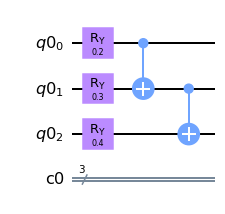

In [12]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

In [13]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir


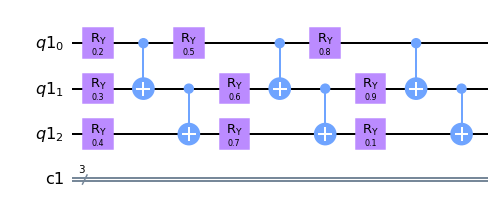

In [14]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

In order to deal with off diagonal blocks, we will also need to form $$ U^{ab} = I\otimes U^a + X \otimes U^b$$

In order to great this gate we need a controled-Ry gate.  The controled-Ry can be built as $C_{R_y}(\phi) = R_y(\phi/2)C_{NOT}R_y(-\phi/2)C_{NOT}$

In [15]:
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

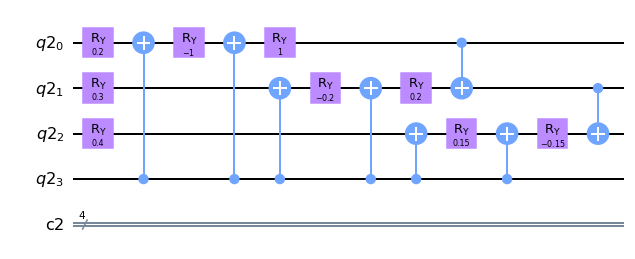

In [16]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

tst.draw(output = 'mpl')

Let's check to make sure we are generating the right thing

In [17]:
#An example block a circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,[0.2,0.3,0.4])

#An example block b circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,[2.2,0.7,0.1])

#The combination of the two blocks
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(Q)
tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

print('A:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
print(qi.Statevector.from_instruction(tst_off).data)

A:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j]
B:
[0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]
AB:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j
 0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]


In [18]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

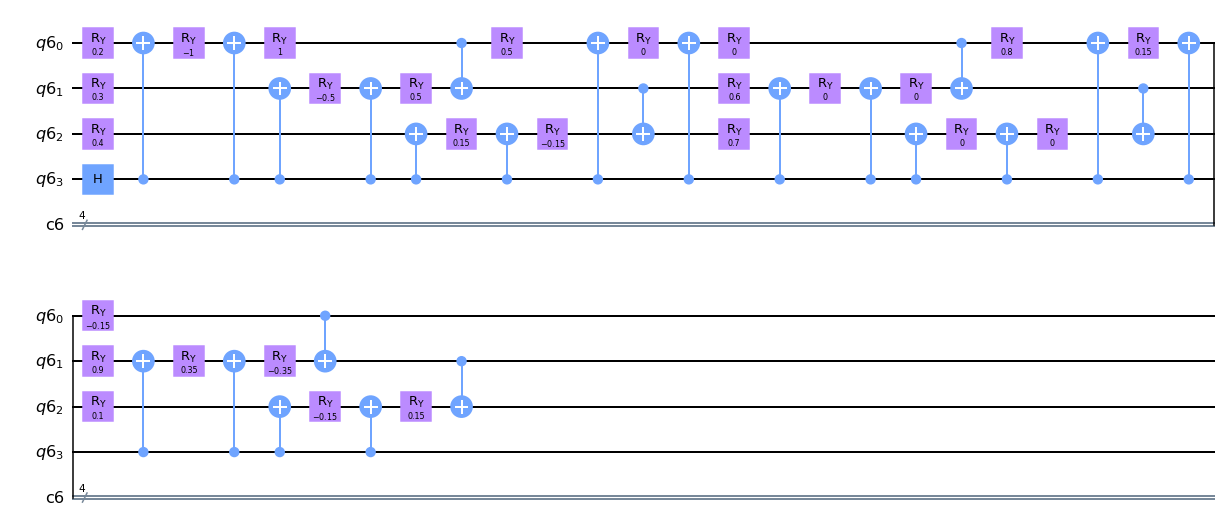

In [19]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]],[[2.2,1.3,0.1],[0.5,0.6,0.7],[0.5,0.2,0.4]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  The we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

### !!! Issue: We only get counts from the quantum computer.  If $<\psi^a|P_{ab,p}|\psi^b> ~< 0$  we will not know !!!

To fix the issue we need to go through the circuit and add a Hadamard gate on each qubit with an X (ect...) then take $(-1)^n$ where n is the number of up qubits with a Puali. 

for example:
$$<\psi|XZ|\psi> = <(R^{\dagger}_y(\pi/2)\otimes I)\psi|R_y(\pi/2)XR^{\dagger}_y(\pi/2)\otimes Z|(R_y(\pi/2)\otimes I)\psi>$$
$$ = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R_y(\pi/2)\otimes I)\psi>$$
$$ = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R_y(\pi/2) \psi>|^2 + (-1)^1|<01|R_y(\pi/2) \psi>|^2 + (-1)^2|<11|R_y(\pi/2) \psi>|^2$$

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



In [20]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def measure_pauli(p_label,psi0,method = 'simple'):
    
    #Simple method of calculation####
    if method == 'simple':
        wave0 = qi.Statevector.from_instruction(psi0)
        Op = qi.Operator.from_label(p_label)
        return np.dot(np.conjugate(wave0),np.dot(Op,wave0))
    #################################
        
    #apply rotations#################
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        wave = qi.Statevector.from_instruction(psi)
        r = wave.probabilities_dict()
        z_measure = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
        return z_measure
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(psi.qubits,psi.clbits)
        r = execute(psi, backend = sim).result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]
        return z_measure/total
    ###################################
    
    raise NameError(method + ' is not a recognized method')
    return method + ' is not a recognized method'
  

#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][17].primitive.to_label()
        
    
print( measure_pauli(p_label,psi0,method = 'simple') )
print( measure_pauli(p_label,psi0,method = 'matrix') )
print( measure_pauli(p_label,psi0,method = 'simulator') )
#print( measure_pauli(p_label,psi0,method = 'Moon_Cheese') )

(0.7209464513295367+0j)
0.7209464513295368
0.7109375


In order to calculate things like 
$$<\psi^a|ZZ|\psi^b>$$ 
we will need to add another qubit and build the combined statevector 
$$ |\psi^{ab}> = |0>|\psi^a> + |1>|\psi_b> $$
then we can calculate
$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = <\psi^{a}|ZZ|\psi^{b}> + <\psi^{b}|ZZ|\psi^{a}>  $$ 

In order to form the combined statevector we need to create a circuit which performs 
$$ U^{ab} = I\otimes U^a + X \otimes U^b$$
In order to great this gate we need a controled-Ry gate.  We see below that the controled-Ry can be built as $C_{R_y}(\phi) = R_y(\phi/2)C_{NOT}R_y(-\phi/2)C_{NOT}$

In [21]:
import random

#number of blocks
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for t in range(T):
        phi_t = []
        for q in range(Q):
            rand = random.random()
            phi_t.append(rand)
        phi_b.append(phi_t)
    phi.append(phi_b)

def E_on_block(phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli( p_label,psi,method = method)
        E += w*E_p
    return E
        
        
block = blocks['0,0']
phi_b = phi[0]

M_b = block.to_matrix()
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,phi_b)
wave = qi.Statevector.from_instruction(psi0).data
print('check:',np.dot(np.conjugate(wave),np.dot(M_b,wave)))

print('simple:',E_on_block(phi_b,block,method = 'simple'))
print('matrix:',E_on_block(phi_b,block,method = 'matrix'))
print('simulator:',E_on_block(phi_b,block,method = 'simulator'))
#print('mooncheese:',E_on_block(phi_b,block,method = 'mooncheese'))

check: (2.7956942418464843+0j)
simple: (2.795694241846485+0j)
matrix: 2.7956942418464843
simulator: 2.84814453125


In [22]:
def E_off_block(phi_a,phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli('X' + p_label,psi,method = method)
        E += w*E_p
    return E

block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]
M_b = block.to_matrix()
#A
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_a = U(cir,phi_a)
wave_a = qi.Statevector.from_instruction(psi_a).data
#B
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_b = U(cir,phi_b)
wave_b = qi.Statevector.from_instruction(psi_b).data
print('check:',np.dot(np.conjugate(wave_a),np.dot(M_b,wave_b)))

print('simple:',E_off_block(phi_a,phi_b,block,method = 'simple'))
print('matrix:',E_off_block(phi_a,phi_b,block,method = 'matrix'))
print('simulator:',E_off_block(phi_a,phi_b,block,method = 'simulator'))
#print('mooncheese:',E_off_block(phi_a,phi_b,block,method = 'mooncheese'))

check: (-0.8104541713298403+0j)
simple: (-0.8104541713298403+0j)
matrix: -0.8104541713298403
simulator: -0.83154296875


Now we need to add all of the blocks together

In [23]:
def find_E(phi,blocks,method = 'simple'):
    E = 0
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            E += E_on_block(phi[int(key[0])],blocks[key],method = 'simple')
        else:
            E += 2*E_off_block(phi[int(key[0])],phi[int(key[2])],blocks[key],method = 'simple')
    return E/bL
            
find_E(phi,blocks)

(1.4117046368694963+0j)

In [24]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

np.dot(np.conjugate(wave_full),np.dot(H_complete,wave_full))/bL


(1.4117046368694963+0j)

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [115]:
#number of blocks
T = 1

phi = []
for b in range(bL):
    phi_b = []
    for t in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)
    
find_E(phi,blocks)

(-0.33333333333333304+0j)

The structure of $\phi_{b,t,q}$ is by section in the first index, by number of application of $U_i$ in the second index, and by qubit in the third index


# Optimization

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [116]:
import copy

In [125]:
#alpha = 0.602
alpha = 0.201
A = 10
a = 0.4
gamma = 0.101
c = 0.4

def SPSA(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    phi_k = np.array(phi)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**alpha)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
            
        #Find E    
        E_A = find_E(phi_k + c_k*Delta_k, blocks, method = method)
        E_B = find_E(phi_k - c_k*Delta_k, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k

        
        #Calculate new E
        E_f = np.real(find_E(phi_k, blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [126]:
out = SPSA(500,method = 'simple',hold = True)

k= 0 c_k= 0.4 a_k= 0.24702451859678626 g= 0.2630007172992074 E_A= (0.6326126967491814+0j) E_B= (0.4222121229098155+0j) E_f= -0.33029107662786444
k= 1 c_k= 0.372954594574733 a_k= 0.24274179599678827 g= -0.7813394869654997 E_A= (0.003735487432241243+0j) E_B= (0.586543790605137+0j) E_f= -0.31456331376065166
k= 2 c_k= 0.3579898757427053 a_k= 0.23886767231070002 g= 0.5867548416698599 E_A= (0.45357685429372907+0j) E_B= (0.0334722685720813+0j) E_f= -0.30525837982153486
k= 3 c_k= 0.34773782403600867 a_k= 0.23533593967153557 g= -1.2424657159341976 E_A= (-0.1726222889812923+0j) E_B= (0.6914823600153068+0j) E_f= -0.27161137400000224
k= 4 c_k= 0.33998833831625347 a_k= 0.23209492713998128 g= 0.07534223812510567 E_A= (0.23222916017610407+0j) E_B= (0.18099819548573975+0j) E_f= -0.2729406429823281
k= 5 c_k= 0.3337849224236992 a_k= 0.2291035795959514 g= 1.4177801510367876 E_A= (0.7452484246651397+0j) E_B= (-0.20121885079020962+0j) E_f= -0.21839461922097397
k= 6 c_k= 0.32862839767254015 a_k= 0.226328767

k= 51 c_k= 0.268375986369122 a_k= 0.17449752108307343 g= 0.33781440569119575 E_A= (-0.385693253694901+0j) E_B= (-0.5670158023690478+0j) E_f= -0.8353790815002293
k= 52 c_k= 0.267860162826851 a_k= 0.17393722653866475 g= -0.603767631355498 E_A= (-0.6684005527321096+0j) E_B= (-0.34494996064317796+0j) E_f= -0.8600125847515461
k= 53 c_k= 0.26735494522142605 a_k= 0.1733875127029373 g= -0.04453576902858869 E_A= (-0.5299832109459848+0j) E_B= (-0.50616949476792+0j) E_f= -0.8597720850977681
k= 54 c_k= 0.2668599250350944 a_k= 0.1728480190624269 g= -0.5995733596721079 E_A= (-0.7126547043072424+0j) E_B= (-0.3926505006769656+0j) E_f= -0.8777169827822127
k= 55 c_k= 0.26637471655715955 a_k= 0.17231840269622573 g= 0.23859679188944447 E_A= (-0.4524889051292571+0j) E_B= (-0.5796012107512538+0j) E_f= -0.879584849701051
k= 56 c_k= 0.2658989552298248 a_k= 0.17179833716619697 g= -0.8280190362230752 E_A= (-0.7584044558015891+0j) E_B= (-0.3180656625173448+0j) E_f= -0.8995977371559998
k= 57 c_k= 0.26543229614067

k= 102 c_k= 0.25047444999544133 a_k= 0.15466470735998908 g= -0.7115989030485823 E_A= (-1.5474025715244208+0j) E_B= (-1.1909278838075148+0j) E_f= -1.6388175564065712
k= 103 c_k= 0.25023014297472496 a_k= 0.15439104836212222 g= 0.4265527383529132 E_A= (-1.261250796120446+0j) E_B= (-1.4747235015290658+0j) E_f= -1.6518998859681995
k= 104 c_k= 0.24998840873867942 a_k= 0.1541202573111085 g= -0.405519526023958 E_A= (-1.4584241642661322+0j) E_B= (-1.2556738022197467+0j) E_f= -1.6599890762500682
k= 105 c_k= 0.24974919607452548 a_k= 0.15385227960119216 g= -0.17229663910550638 E_A= (-1.4341297819745105+0j) E_B= (-1.3480678877686247+0j) E_f= -1.6591171041779078
k= 106 c_k= 0.2495124552599996 a_k= 0.15358706212572473 g= 0.5749807040465725 E_A= (-1.2353026222826209+0j) E_B= (-1.5222323166701879+0j) E_f= -1.676425899799724
k= 107 c_k= 0.24927813800651724 a_k= 0.1533245532236118 g= 0.24620771141940276 E_A= (-1.3611774894191637+0j) E_B= (-1.483925889150113+0j) E_f= -1.6786030887306709
k= 108 c_k= 0.2490

k= 153 c_k= 0.24050294487280224 a_k= 0.14350808787580852 g= -0.29575869326683346 E_A= (-1.708612204912587+0j) E_B= (-1.5663505315077764+0j) E_f= -1.893469025665738
k= 154 c_k= 0.24034577371294386 a_k= 0.14333284411377514 g= 0.05441067764151405 E_A= (-1.598937871307358+0j) E_B= (-1.6250926241393486+0j) E_f= -1.8935713309195203
k= 155 c_k= 0.2401897150315199 a_k= 0.1431588712952899 g= -0.37957313171008794 E_A= (-1.7348741033204185+0j) E_B= (-1.5525349786422833+0j) E_f= -1.904624615293379
k= 156 c_k= 0.24003475389827156 a_k= 0.1429861526294766 g= 0.42294299043017497 E_A= (-1.5718482043274706+0j) E_B= (-1.7748902375692828+0j) E_f= -1.914516251945446
k= 157 c_k= 0.23988087567680955 a_k= 0.14281467164615091 g= -0.3238577971946288 E_A= (-1.7440036112638346+0j) E_B= (-1.5886290272922143+0j) E_f= -1.9212882868815424
k= 158 c_k= 0.239728066017013 a_k= 0.14264441218782992 g= -0.2160610960220377 E_A= (-1.6947667312376826+0j) E_B= (-1.5911749138559241+0j) E_f= -1.9225035769465584
k= 159 c_k= 0.2395

k= 203 c_k= 0.23376922896323718 a_k= 0.13603379779884953 g= -0.01884947414745212 E_A= (-1.7773453626276616+0j) E_B= (-1.768532508552037+0j) E_f= -2.0238586572577337
k= 204 c_k= 0.23365380153244633 a_k= 0.13590638504418354 g= 0.04445813271949855 E_A= (-1.8062223029049167+0j) E_B= (-1.8269979263428064+0j) E_f= -2.0242026649008635
k= 205 c_k= 0.23353899237344763 a_k= 0.13577968204298357 g= -0.18740477623086285 E_A= (-1.810873936479351+0j) E_B= (-1.7233412912654966+0j) E_f= -2.024140063101661
k= 206 c_k= 0.23342479519724088 a_k= 0.13565368158301086 g= -0.14420120331538597 E_A= (-1.8673964540635366+0j) E_B= (-1.8000761813613573+0j) E_f= -2.025888478272285
k= 207 c_k= 0.23331120380879006 a_k= 0.13552837655812258 g= -0.1608456760987535 E_A= (-1.800788001469071+0j) E_B= (-1.725733804832993+0j) E_f= -2.0276356715287247
k= 208 c_k= 0.2331982121051757 a_k= 0.13540375996623283 g= 0.18155231393189233 E_A= (-1.7444612415813623+0j) E_B= (-1.829136591606312+0j) E_f= -2.0303669232416492
k= 209 c_k= 0.2

k= 254 c_k= 0.22855958199258958 a_k= 0.1303129482877117 g= -0.09603084574439458 E_A= (-1.8662720064560674+0j) E_B= (-1.8223744665326+0j) E_f= -2.064652715281583
k= 255 c_k= 0.22846924936970905 a_k= 0.13021433050533257 g= -0.1606746194921162 E_A= (-1.8401180966900257+0j) E_B= (-1.7666996772737709+0j) E_f= -2.0655935180826805
k= 256 c_k= 0.22837930441497245 a_k= 0.13011615698394097 g= 0.011515727582217047 E_A= (-1.8414109675949117+0j) E_B= (-1.8466708753050298+0j) E_f= -2.065576493137006
k= 257 c_k= 0.22828974396591784 a_k= 0.13001842406950276 g= -0.23285705300380174 E_A= (-1.9614380267539986+0j) E_B= (-1.8551202727322065+0j) E_f= -2.0684473358444344
k= 258 c_k= 0.22820056489801344 a_k= 0.1299211281515303 g= -0.11001259288412371 E_A= (-1.8777632211155129+0j) E_B= (-1.8275533494314085+0j) E_f= -2.068915327469443
k= 259 c_k= 0.22811176412405826 a_k= 0.12982426566240393 g= -0.2647996268757603 E_A= (-1.9137254246516968+0j) E_B= (-1.7929176045996527+0j) E_f= -2.0727370288964906
k= 260 c_k= 0.

k= 304 c_k= 0.22446348815402628 a_k= 0.1258634320734495 g= -0.10690256904215586 E_A= (-1.8571937033179+0j) E_B= (-1.8092022562382422+0j) E_f= -2.101768065935648
k= 305 c_k= 0.22438929147512626 a_k= 0.12578327196545175 g= -0.15439475236835373 E_A= (-1.940425815259741+0j) E_B= (-1.871136757076916+0j) E_f= -2.1035192243445433
k= 306 c_k= 0.2243153612798253 a_k= 0.12570341593919337 g= 0.021695155021837935 E_A= (-1.8992921861133927+0j) E_B= (-1.9090252991868835+0j) E_f= -2.10345493309214
k= 307 c_k= 0.2242416957476633 a_k= 0.1256238618873561 g= 0.05843768213962369 E_A= (-1.8960808373842677+0j) E_B= (-1.922289167261372+0j) E_f= -2.103694594953096
k= 308 c_k= 0.22416829307647623 a_k= 0.12554460772379422 g= -0.08347656414599008 E_A= (-1.8828126807147296+0j) E_B= (-1.8453870829217385+0j) E_f= -2.1044992161892337
k= 309 c_k= 0.22409515148215373 a_k= 0.12546565138325588 g= 0.06209582629426621 E_A= (-1.845167252951475+0j) E_B= (-1.8729980001511213+0j) E_f= -2.1047362990976874
k= 310 c_k= 0.2240222

k= 354 c_k= 0.2210481719458794 a_k= 0.12219097370048973 g= -0.038228838515684906 E_A= (-1.90919893756932+0j) E_B= (-1.8922981078303072+0j) E_f= -2.110142813459724
k= 355 c_k= 0.22098537951573047 a_k= 0.12212379545425779 g= -0.04632007458491714 E_A= (-1.907766258190478+0j) E_B= (-1.8872941396677883+0j) E_f= -2.110014873156321
k= 356 c_k= 0.22092278098392504 a_k= 0.12205683728727247 g= -0.01885008433088408 E_A= (-1.9532387867192216+0j) E_B= (-1.9449099606149007+0j) E_f= -2.1099886143750908
k= 357 c_k= 0.2208603752110963 a_k= 0.12199009788181196 g= 0.04842799699976783 E_A= (-1.9288591501340244+0j) E_B= (-1.9502508013102056+0j) E_f= -2.1102419614247934
k= 358 c_k= 0.22079816106773162 a_k= 0.12192357593159786 g= -0.05614649953878364 E_A= (-1.9538853152874256+0j) E_B= (-1.9290912275903183+0j) E_f= -2.1103981386872626
k= 359 c_k= 0.22073613743405993 a_k= 0.12185727014166509 g= -0.044723406958814695 E_A= (-1.9453474218942024+0j) E_B= (-1.9256032776842418+0j) E_f= -2.1108342931366666
k= 360 c_k

k= 404 c_k= 0.2181257984204375 a_k= 0.11907821719450758 g= 0.07522483550600605 E_A= (-1.8966335297258798+0j) E_B= (-1.9294504843374671+0j) E_f= -2.113590232201043
k= 405 c_k= 0.2180714754281335 a_k= 0.11902062647279299 g= 0.026641157902134345 E_A= (-1.9032469098951632+0j) E_B= (-1.9148662631168278+0j) E_f= -2.113649681324702
k= 406 c_k= 0.2180172995508166 a_k= 0.11896320177708 g= -0.0278020275502102 E_A= (-1.9427813340766833+0j) E_B= (-1.9306586881396148+0j) E_f= -2.1135352348771876
k= 407 c_k= 0.21796327003008015 a_k= 0.11890594223231293 g= 0.03306449287411592 E_A= (-1.8961511686908197+0j) E_B= (-1.9105648586682769+0j) E_f= -2.1133791647095297
k= 408 c_k= 0.2179093861132739 a_k= 0.1188488469701276 g= 0.018769533305562212 E_A= (-1.927553095979355+0j) E_B= (-1.9357332109398504+0j) E_f= -2.1133818993280897
k= 409 c_k= 0.21785564705344662 a_k= 0.11879191512878434 g= 0.05081632338063384 E_A= (-1.8720953877759823+0j) E_B= (-1.8942366337979126+0j) E_f= -2.113361991094834
k= 410 c_k= 0.217802

k= 454 c_k= 0.21557621389665993 a_k= 0.11638632302225908 g= -0.0008490830845453752 E_A= (-1.948324121632072+0j) E_B= (-1.947958037398772+0j) E_f= -2.1140851526702695
k= 455 c_k= 0.21552841852324142 a_k= 0.1163360789620428 g= -0.03701148303618659 E_A= (-1.9468284298224767+0j) E_B= (-1.9308743770104986+0j) E_f= -2.114041755390338
k= 456 c_k= 0.21548073841143345 a_k= 0.11628596422692798 g= 0.019114902667664708 E_A= (-1.9186971551954413+0j) E_B= (-1.9269349418784234+0j) E_f= -2.113935304919738
k= 457 c_k= 0.2154331730319722 a_k= 0.11623597820817949 g= 0.01007844446797258 E_A= (-1.890687119153232+0j) E_B= (-1.8950295816951557+0j) E_f= -2.1139545133210818
k= 458 c_k= 0.21538572185917312 a_k= 0.11618612030122055 g= -0.008302840500038638 E_A= (-1.9022195345463064+0j) E_B= (-1.8986429079571416+0j) E_f= -2.11392290220234
k= 459 c_k= 0.2153383843708989 a_k= 0.1161363899055954 g= -0.02039168955775982 E_A= (-1.9648451141229395+0j) E_B= (-1.9560628871550176+0j) E_f= -2.11389281260927
k= 460 c_k= 0.2

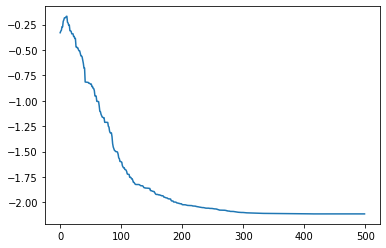

In [127]:
import matplotlib.pyplot as plt

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [128]:
import pickle

file_to_store = open("VQE_Gunlycke_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_alpha_"+str(alpha)+"_gamma_"+str(gamma)+".pickle", "wb")

pickle.dump(out, file_to_store)

In [129]:
import pickle

file_to_read = open("VQE_Gunlycke_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_alpha_"+str(alpha)+"_gamma_"+str(gamma)+".pickle", "rb")

loaded_object = pickle.load(file_to_read)

EOFError: Ran out of input

In [ ]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [364]:
def SPSA_from_load(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    #alpha = 0.602
    alpha = 0.201
    A = 10
    a = 0.6
    gamma = 0.101
    c = 0.4
    phi_k = np.array(phi)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**alpha)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = loaded_object[k]['Delta']
        
            
        #Find E    
        E_A = find_E(phi_k + c_k*Delta_k, blocks, method = method)
        E_B = find_E(phi_k - c_k*Delta_k, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k

        
        #Calculate new E
        E_f = np.real(find_E(phi_k, blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [365]:
El,psi_f = SPSA_from_load(500,method = 'simple',hold = False)

k= 0 c_k= 0.4 a_k= 0.37053677789517936 g= 0.31221237166560845 E_A= (0.6483890629959139+0j) E_B= (0.39861916566342714+0j) E_f= -0.2941674404659663
k= 1 c_k= 0.372954594574733 a_k= 0.36411269399518237 g= -0.26600035420340845 E_A= (0.2901614058922417+0j) E_B= (0.48857351440957686+0j) E_f= -0.2754518896460993
k= 2 c_k= 0.3579898757427053 a_k= 0.35830150846605 g= -0.23292677706300263 E_A= (0.29719469765243134+0j) E_B= (0.4639655536082976+0j) E_f= -0.2587121931480509
k= 3 c_k= 0.34773782403600867 a_k= 0.3530039095073033 g= 0.21234021146877308 E_A= (0.4327031217365752+0j) E_B= (0.28502567555358105+0j) E_f= -0.2459624290385531
k= 4 c_k= 0.33998833831625347 a_k= 0.3481423907099719 g= -0.8282619743549222 E_A= (0.03284742681671075+0j) E_B= (0.5960462515196494+0j) E_f= -0.08100027444187621
k= 5 c_k= 0.3337849224236992 a_k= 0.3436553693939271 g= -0.7447356728411818 E_A= (0.2115041071735653+0j) E_B= (0.7086671847444759+0j) E_f= 0.038152202417291815
k= 6 c_k= 0.32862839767254015 a_k= 0.33949315101716

k= 52 c_k= 0.267860162826851 a_k= 0.2609058398079971 g= -0.6637781002455034 E_A= (-1.0971474553042815+0j) E_B= (-0.7415480352789647+0j) E_f= -1.0994263698402225
k= 53 c_k= 0.26735494522142605 a_k= 0.26008126905440593 g= 1.407911354082114 E_A= (-0.5476712911724904+0j) E_B= (-1.3004954170669851+0j) E_f= -1.2750908604996083
k= 54 c_k= 0.2668599250350944 a_k= 0.2592720285936403 g= 0.3115613639478683 E_A= (-1.0104499459650993+0j) E_B= (-1.176736430419019+0j) E_f= -1.2814667599546898
k= 55 c_k= 0.26637471655715955 a_k= 0.25847760404433856 g= 0.1171148371603351 E_A= (-1.027592537004671+0j) E_B= (-1.0899854001111153+0j) E_f= -1.2818743830349033
k= 56 c_k= 0.2658989552298248 a_k= 0.2576975057492954 g= 0.5293579784046106 E_A= (-0.8792011062133299+0j) E_B= (-1.1607125730140462+0j) E_f= -1.282086350580811
k= 57 c_k= 0.26543229614067565 a_k= 0.2569312672388709 g= -0.139467602267511 E_A= (-1.0908689506251905+0j) E_B= (-1.0168305388109906+0j) E_f= -1.2801628270984842
k= 58 c_k= 0.26497441264651617 a_

k= 103 c_k= 0.25023014297472496 a_k= 0.23158657254318332 g= 0.16197514333165727 E_A= (-1.5241987206105965+0j) E_B= (-1.6052608471590608+0j) E_f= -1.7613944770531855
k= 104 c_k= 0.24998840873867942 a_k= 0.23118038596666274 g= -0.10559690922187386 E_A= (-1.610454788001996+0j) E_B= (-1.5576587813937979+0j) E_f= -1.76175682998874
k= 105 c_k= 0.24974919607452548 a_k= 0.2307784194017882 g= 0.23095575564585205 E_A= (-1.5114396716308858+0j) E_B= (-1.626801700233558+0j) E_f= -1.7663220086037088
k= 106 c_k= 0.2495124552599996 a_k= 0.23038059318858709 g= 0.35943278297641235 E_A= (-1.4573368947696406+0j) E_B= (-1.636702807132399+0j) E_f= -1.7735644700799984
k= 107 c_k= 0.24927813800651724 a_k= 0.22998682983541768 g= 0.3459481684476991 E_A= (-1.506252183827228+0j) E_B= (-1.6787268143820429+0j) E_f= -1.781116290224153
k= 108 c_k= 0.24904619740500722 a_k= 0.22959705394216187 g= -0.07873932143333032 E_A= (-1.6728575169562512+0j) E_B= (-1.6336380597778082+0j) E_f= -1.7823494830513171
k= 109 c_k= 0.2488

k= 153 c_k= 0.24050294487280224 a_k= 0.21526213181371276 g= 0.008744785336365263 E_A= (-1.7012406417363366+0j) E_B= (-1.7054469349876893+0j) E_f= -1.8713081976727461
k= 154 c_k= 0.24034577371294386 a_k= 0.2149992661706627 g= 0.22835649338188035 E_A= (-1.6435933200044097+0j) E_B= (-1.7533623561728953+0j) E_f= -1.8746302585197436
k= 155 c_k= 0.2401897150315199 a_k= 0.2147383069429348 g= -0.11426817501444562 E_A= (-1.7170791951622109+0j) E_B= (-1.6621871143744278+0j) E_f= -1.8751852786255994
k= 156 c_k= 0.24003475389827156 a_k= 0.21447922894421484 g= -0.28188096762304243 E_A= (-1.780900692284657+0j) E_B= (-1.6455782349006498+0j) E_f= -1.8829435060946635
k= 157 c_k= 0.23988087567680955 a_k= 0.21422200746922634 g= -0.1585448649172057 E_A= (-1.6936271332024946+0j) E_B= (-1.617563371141693+0j) E_f= -1.884116907322624
k= 158 c_k= 0.239728066017013 a_k= 0.21396661828174487 g= -0.16711155153215504 E_A= (-1.7323649605872646+0j) E_B= (-1.6522423024714528+0j) E_f= -1.8846123935717023
k= 159 c_k= 0.

k= 203 c_k= 0.23376922896323718 a_k= 0.20405069669827428 g= 0.13578834536009146 E_A= (-1.6945963510230346+0j) E_B= (-1.7580826246170793+0j) E_f= -1.9496523984210854
k= 204 c_k= 0.23365380153244633 a_k= 0.2038595775662753 g= -0.055417386332366134 E_A= (-1.7638914421314666+0j) E_B= (-1.7379944761563675+0j) E_f= -1.950437165964479
k= 205 c_k= 0.23353899237344763 a_k= 0.20366952306447533 g= -0.11792461007270193 E_A= (-1.795947970823381+0j) E_B= (-1.74086798159856+0j) E_f= -1.9518037972365203
k= 206 c_k= 0.23342479519724088 a_k= 0.20348052237451628 g= -0.09071368922306194 E_A= (-1.6991096595159274+0j) E_B= (-1.6567600108589686+0j) E_f= -1.9520031840421188
k= 207 c_k= 0.23331120380879006 a_k= 0.20329256483718383 g= 0.0483423105819938 E_A= (-1.7528395583647574+0j) E_B= (-1.7753971637183241+0j) E_f= -1.9525761027164394
k= 208 c_k= 0.2331982121051757 a_k= 0.20310563994934921 g= -0.0935832220514162 E_A= (-1.7761447814022004+0j) E_B= (-1.7324979012713366+0j) E_f= -1.9536927717094683
k= 209 c_k= 0

k= 253 c_k= 0.22865030548461726 a_k= 0.19561802104402623 g= 0.0493258290739389 E_A= (-1.7798753465321824+0j) E_B= (-1.8024320783042587+0j) E_f= -1.9759434919769092
k= 254 c_k= 0.22855958199258958 a_k= 0.19546942243156754 g= -0.057220595838998106 E_A= (-1.798263763672948+0j) E_B= (-1.7721071327402913+0j) E_f= -1.9763447043090334
k= 255 c_k= 0.22846924936970905 a_k= 0.19532149575799884 g= 0.05709263782042086 E_A= (-1.7882460155971356+0j) E_B= (-1.814333839811872+0j) E_f= -1.9766798247858155
k= 256 c_k= 0.22837930441497245 a_k= 0.19517423547591145 g= 0.031779577093912076 E_A= (-1.801824982732855+0j) E_B= (-1.8163405781554742+0j) E_f= -1.976889071770436
k= 257 c_k= 0.22828974396591784 a_k= 0.1950276361042541 g= 0.03729601650757049 E_A= (-1.791113483104523+0j) E_B= (-1.8081420792234468+0j) E_f= -1.9768232738242546
k= 258 c_k= 0.22820056489801344 a_k= 0.19488169222729543 g= 0.006766089520059693 E_A= (-1.820123037684761+0j) E_B= (-1.8232110885860173+0j) E_f= -1.9768788105756334
k= 259 c_k= 0.

k= 303 c_k= 0.2245379531555281 a_k= 0.1889158475879403 g= -0.019615701884670322 E_A= (-1.7602038357017515+0j) E_B= (-1.7513948965999657+0j) E_f= -1.98032834121638
k= 304 c_k= 0.22446348815402628 a_k= 0.18879514811017423 g= -0.015041963527366373 E_A= (-1.807511441626499+0j) E_B= (-1.8007586984224224+0j) E_f= -1.9804480317890927
k= 305 c_k= 0.22438929147512626 a_k= 0.1886749079481776 g= -0.005379159727201483 E_A= (-1.7702282511470542+0j) E_B= (-1.7678141994672176+0j) E_f= -1.9804321975331283
k= 306 c_k= 0.2243153612798253 a_k= 0.18855512390879003 g= -0.034871426066510405 E_A= (-1.7960331364346231+0j) E_B= (-1.7803887433617192+0j) E_f= -1.9805199722103088
k= 307 c_k= 0.2242416957476633 a_k= 0.18843579283103418 g= -0.032066339120264485 E_A= (-1.7986848505079438+0j) E_B= (-1.7843036299864483+0j) E_f= -1.980643996427383
k= 308 c_k= 0.22416829307647623 a_k= 0.1883169115856913 g= 0.016437240735645058 E_A= (-1.8042523980589036+0j) E_B= (-1.811621814456097+0j) E_f= -1.9806908605402178
k= 309 c_k

k= 353 c_k= 0.22111115942370668 a_k= 0.18338756003289805 g= 0.03882221520856018 E_A= (-1.7998008757955735+0j) E_B= (-1.8169689258278963+0j) E_f= -1.9820295317492296
k= 354 c_k= 0.2210481719458794 a_k= 0.18328646055073458 g= 0.0071509458131375405 E_A= (-1.8159274534849292+0j) E_B= (-1.8190888604842854+0j) E_f= -1.982010473015273
k= 355 c_k= 0.22098537951573047 a_k= 0.18318569318138667 g= -0.0019019534642685481 E_A= (-1.8242452398534958+0j) E_B= (-1.8234046320372506+0j) E_f= -1.9820130283647297
k= 356 c_k= 0.22092278098392504 a_k= 0.18308525593090869 g= -0.0038706887352812466 E_A= (-1.8230589603195704+0j) E_B= (-1.8213487136801274+0j) E_f= -1.981995495332018
k= 357 c_k= 0.2208603752110963 a_k= 0.1829851468227179 g= -0.02755966959595011 E_A= (-1.7940244271544605+0j) E_B= (-1.7818507492191498+0j) E_f= -1.9818850452459345
k= 358 c_k= 0.22079816106773162 a_k= 0.1828853638973968 g= -0.025775513851473135 E_A= (-1.7944604951253116+0j) E_B= (-1.7830781230073494+0j) E_f= -1.98201530577851
k= 359 

k= 403 c_k= 0.2181802692919501 a_k= 0.178703962236058 g= -0.010292584394149944 E_A= (-1.8269843762250224+0j) E_B= (-1.822493098555371+0j) E_f= -1.9821872263662588
k= 404 c_k= 0.2181257984204375 a_k= 0.17861732579176134 g= -0.01397943804524545 E_A= (-1.8192733892152475+0j) E_B= (-1.813174837045071+0j) E_f= -1.9821662925072885
k= 405 c_k= 0.2180714754281335 a_k= 0.17853093970918948 g= 0.004043741360277849 E_A= (-1.7976272361660897+0j) E_B= (-1.7993908854554608+0j) E_f= -1.9821446936108817
k= 406 c_k= 0.2180172995508166 a_k= 0.17844480266562 g= 0.005504211774597279 E_A= (-1.7852497522691575+0j) E_B= (-1.7876497790436645+0j) E_f= -1.982131343482575
k= 407 c_k= 0.21796327003008015 a_k= 0.17835891334846937 g= 0.0011722443329561072 E_A= (-1.801086633472+0j) E_B= (-1.8015976458881706+0j) E_f= -1.9821261851195617
k= 408 c_k= 0.2179093861132739 a_k= 0.1782732704551914 g= 0.00961478644325766 E_A= (-1.8063669744072754+0j) E_B= (-1.8105572788301965+0j) E_f= -1.982162633667444
k= 409 c_k= 0.21785564

k= 453 c_k= 0.2156241250645643 a_k= 0.17465504553076158 g= 0.009446685368866442 E_A= (-1.8186774143847995+0j) E_B= (-1.8227512809196436+0j) E_f= -1.9826608724809287
k= 454 c_k= 0.21557621389665993 a_k= 0.17457948453338862 g= 0.0191982866251469 E_A= (-1.8247353705263607+0j) E_B= (-1.8330127584142648+0j) E_f= -1.9827637711465338
k= 455 c_k= 0.21552841852324142 a_k= 0.17450411844306418 g= -0.011228681778111526 E_A= (-1.803329787273987+0j) E_B= (-1.7984895872225128+0j) E_f= -1.9827469403049183
k= 456 c_k= 0.21548073841143345 a_k= 0.17442894634039197 g= -0.00574623040761278 E_A= (-1.7894589045678506+0j) E_B= (-1.7869825006252213+0j) E_f= -1.9827223173735788
k= 457 c_k= 0.2154331730319722 a_k= 0.1743539673122692 g= -0.007685584631084743 E_A= (-1.8168967167008234+0j) E_B= (-1.8135852569334627+0j) E_f= -1.9826985403407287
k= 458 c_k= 0.21538572185917312 a_k= 0.1742791804518308 g= 0.0124803870127395 E_A= (-1.802406528289735+0j) E_B= (-1.8077827226213765+0j) E_f= -1.982694716952244
k= 459 c_k= 0

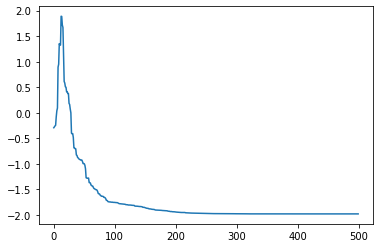

In [367]:
import matplotlib.pyplot as plt

tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [30]:
pwd

'C:\\Users\\jsten\\IBMQ\\Hubbard_symmetries'